In [1]:
import torch
import theseus as th
import matplotlib.pyplot as plt
from mcf4pingpong.draw_util import set_axes_equal
from typing import Tuple, Sequence
import plotly.graph_objs as go
from plotly.offline import iplot



In [2]:

'''
This is a toy example for trajectory g = [0,0,-9.8]
    1. generate trajectory for a = g, t = [0,2] sec
    2. add random noise 
    3. optimize to denoise

     p0 ----- p1------p2
          |       |
         V0 ---- V1
'''

def generate_trajectory(visualize = False):
    def euler_int(carry, dt):
       p0, v0 = carry
       p1 = p0 + v0 * dt
       v1 =  v0 + torch.tensor([0.0,0.0,-9.8])*dt
       return (p1, v1), p1
    N=40
    v0 = torch.tensor([5.0,0.0,0.0])
    p0 = torch.tensor([0.0,0.0,0.0])
    t = torch.linspace(0.0,2.0,N)
    dts = torch.diff(t)
    
    pN = [p0]
    for dt in dts:
        (p0,v0), p0 = euler_int((p0,v0),dt)
        pN.append(p0)
    pN = torch.vstack(pN)
    noise_scale = 0.30  # Standard deviation of the noise
    noise = noise_scale *  torch.randn((N, 3))
    pN_noisy = pN + noise
    if visualize:
        fig= plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(*pN_noisy.T)
        set_axes_equal(ax)
        plt.show()

    return t, pN_noisy, pN

def pos_prior_errfn(optim_vars: Tuple[th.Variable], aux_vars: Tuple[th.Variable]):
    li, = optim_vars 
    li_prior, = aux_vars
    err = li.tensor - li_prior.tensor
    return err

def pos_between_errfn(optim_vars: Tuple[th.Variable,...], aux_vars: float):
    li_prev, vi_prev, li = optim_vars 
    dt = aux_vars[0].tensor
    err = li_prev.tensor + vi_prev.tensor * dt - li.tensor
    return err

def vel_between_errfn(optim_vars: Tuple[th.Variable,...], aux_vars: float):
    vel_prev2, vi_prev = optim_vars 
    dt = aux_vars[0].tensor
    err = vel_prev2.tensor + torch.tensor([[0.0,0.0,-9.8]])*dt - vi_prev.tensor
    return err
    

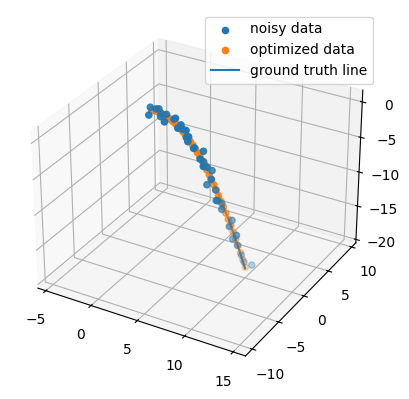

In [3]:
t, pN_noisy, pN_clean = generate_trajectory(visualize=False)
objective = th.Objective()
theseus_inputs = {}
weight_l_prior = th.ScaleCostWeight(0.1)

# li_prev, t_prev2, t_prev, vi_prev2 = [None]*4
for i, (ti, pi) in enumerate(zip(t, pN_noisy)):
    li = th.Vector(3, name=f"l{i}")
    theseus_inputs.update({f'l{i}': torch.zeros(1,3)})

    
    li_prior = th.Variable(pi.reshape((1,3)), name=f"l{i}_prior")
    # theseus_inputs.update({f'l{i}_prior': torch.zeros(1,3)})
    cost_function = th.AutoDiffCostFunction((li,), pos_prior_errfn, 3, aux_vars=(li_prior,), name=f"l{i}_prior_erfn", cost_weight=weight_l_prior)
    objective.add(cost_function)
        
    if i>0:
        vi_prev = th.Vector(3, name=f"v{i-1}")
        dt_prev = th.Variable(torch.tensor([[ti-t_prev]]),name=f'dt{i-1}') 
        theseus_inputs.update({f"v{i-1}": torch.zeros(1,3), f'dt{i-1}': torch.tensor([[ti-t_prev]])})

        cost_function = th.AutoDiffCostFunction((li_prev, vi_prev, li), pos_between_errfn, 3, aux_vars=(dt_prev,), name=f"pose_between{i}")
        objective.add(cost_function)
        

    if i>1:
        cost_function = th.AutoDiffCostFunction((vi_prev2, vi_prev), vel_between_errfn, 3, aux_vars=(dt_prev2,), name=f"vel_between{i}")
        objective.add(cost_function)

    li_prev = li
    t_prev = ti
    if i >0:
        vi_prev2 = vi_prev
        dt_prev2 = dt_prev
# for k,v in theseus_inputs.items():
#     print(f"{k}:{v}")
optimizer = th.LevenbergMarquardt(objective, max_iterations=20, step_size=0.4)
theseus_optim = th.TheseusLayer(optimizer)
updated_inputs, _ = theseus_optim.forward(theseus_inputs)


pN_opt, vN_opt = [],[]
for k,v in updated_inputs.items():
    if 'l' in k:
        pN_opt.append(v)
    elif 'v' in k:
        vN_opt.append(v)
pN_opt = torch.vstack(pN_opt)

fig= plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*pN_noisy.T, label='noisy data')
ax.scatter(*pN_opt.T, label='optimized data')
ax.plot(*pN_clean.numpy().T, label='ground truth line')
set_axes_equal(ax)
ax.legend()
plt.show()

In [20]:
# Create trace
trace1 = go.Scatter3d(
    x=pN_noisy[:,0],
    y=pN_noisy[:,1],
    z=pN_noisy[:,2],
    mode='markers',
    marker=dict(
        size=2,
    ),
    name='noisy'

)

trace2 = go.Scatter3d(
    x=pN_opt[:,0],
    y=pN_opt[:,1],
    z=pN_opt[:,2],
    mode='markers',
    marker=dict(
        size=2,
    ),
    name = 'opt'
)


max_range = (torch.max(pN_noisy,0)[0] - torch.min(pN_noisy,0)[0]).max()/2.0
mid_x, mid_y, mid_z = (torch.max(pN_noisy,0)[0] +torch.min(pN_noisy,0)[0])/2.0

# Create layout
layout = go.Layout(title='Plot with Legend Labels',
    xaxis=dict(title='X-axis Label'),
    yaxis=dict(title='Y-axis Label'),
    legend=dict(title='Legend'),
    scene=dict(
                    xaxis=dict(range=[mid_x-max_range, mid_x+max_range]),
                    yaxis=dict(range=[mid_y-max_range, mid_y+max_range]),
                    zaxis=dict(range=[mid_z-max_range, mid_z+max_range]),
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=1)),
                  width=700, height=700)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)


fig.show()
